## Satellite images multi-class classification

Here the selected dataset is the EuroSATA RGB dataset based on Sentinel-2 satellite images ([source](http://madm.dfki.de/downloads)).

In [0]:
!wget http://madm.dfki.de/files/sentinel/EuroSAT.zip
!unzip /content/EuroSAT.zip

## Pre-trained classifier

In [3]:
from torchvision import models, transforms
from torchsummary import summary
import torch.optim as optim
import torch.nn as nn
import torch

from torch.utils.data.sampler import Sampler
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

import requests
import time
import copy
import shutil
import ntpath
import os

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report

In [0]:
train_data= requests.get('https://raw.githubusercontent.com/rslab-ntua/MSc_GBDA/master/2020/Exercise_ML2/train_split.json').json()
test_data = requests.get('https://raw.githubusercontent.com/rslab-ntua/MSc_GBDA/master/2020/Exercise_ML2/test_split.json').json()
val_data = requests.get('https://raw.githubusercontent.com/rslab-ntua/MSc_GBDA/master/2020/Exercise_ML2/val_split.json').json()

The folder structure is organized in such a way, in order for the ImageFolder DataLoader to be leveraged. In specific, three folders are created in order to include the test, train and validation datasets. The images that belong to each dataset are moved to the corresponding folder.

In [0]:
!mkdir data
!mkdir data/train
!mkdir data/test
!mkdir data/val

In [0]:
for path in train_data:
    respath, filename = ntpath.split(path)
    _, cat = ntpath.split(respath)
    os.makedirs(os.path.join('data/train/'+cat), exist_ok=True)
    shutil.copy(path, 'data/train/'+cat+'/'+filename)

In [0]:
for path in test_data:
    respath, filename = ntpath.split(path)
    _, cat = ntpath.split(respath)
    os.makedirs(os.path.join('data/test/'+cat), exist_ok=True)
    shutil.copy(path, 'data/test/'+cat+'/'+filename)

In [0]:
for path in val_data:
    respath, filename = ntpath.split(path)
    _, cat = ntpath.split(respath)
    os.makedirs(os.path.join('data/val/'+cat), exist_ok=True)
    shutil.copy(path, 'data/val/'+cat+'/'+filename)

The number of classes is set to 10, that is as many as the available data categories. The selected pre-trained CNN is Resnet18.

In [8]:
num_classes = 10
model_ft = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


Below is depicted the structure of the pretrained CNN.

In [60]:
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In order to train only the last layers of the pre-trained network and perform feature extracting, the requre_grad flag is set to False. In this way the back propation does not concern those layers, whose weights and parameters stay unchanged. The last fully connected layer of the network is replaced with another linear layer with the same number of input features and 10 output features. Moreover, the Resent network receives as input 224x224 3-channel images, and therefore the input size of the network and the output size of the transformation sequence imposed on the dataset is set to 224x224 pixels.

In [0]:
for param in model_ft.parameters():
    param.requires_grad = False 

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)
input_size = 224
device = 'cuda'

In order to extend the dataset, two data augmentation techniques are applied on the trainset. These are RandomResizedCrop, that crops randomely the input image to the specified size, and RandomHorizontalFlip, which mirrors the input image with the default probability of 0.5. Both test and validation datasets are processed as far as the size of the images is concerned in order to be compliant with the pre-trained CNN's specifications. All three datasets are normalized according to the hard-coded values that are provided in the PyTorch documentation.

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [0]:
folder_test = ImageFolder('/content/data/test', transform=data_transforms['test'])
folder_train = ImageFolder('/content/data/train', transform=data_transforms['train'])
folder_val = ImageFolder('/content/data/val', transform=data_transforms['val'])

classes = folder_train.class_to_idx

The following function has reference the corresponing function in the [PyTorch documentation](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html). The baseline code from the documentation has been edited accordingly in order to return all significant values.

In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_train_acc, best_train_loss= 0.0, 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

            if phase == 'train' and epoch_acc > best_train_acc:
                best_train_acc = epoch_acc
                best_train_loss = epoch_loss

        
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, best_acc, best_loss, best_train_acc, best_train_loss

The selcted loss function is CrossEntropyLoss.

In [0]:
criterion = nn.CrossEntropyLoss()

In [0]:
train_dl = DataLoader(folder_train, batch_size=200, shuffle=True)
val_dl = DataLoader(folder_val, batch_size=200)
test_dl = DataLoader(folder_test)

dataloaders_dict = {'train':train_dl,'val':val_dl}

During the validation phase of the network's training, all hyper-parameters are kept constant with the exception of the batch size. By trying three different values, the corresponding validation accuracies are compared in order to define the best batch size value.

In [13]:
model_ft= model_ft.to(device)

epoch = 10
best_accuracy = 0.0 
best_batchsize = 0
for batch_size in [100, 200, 500]:
    model = copy.deepcopy(model_ft)
    optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=0.01)

    train_dl = DataLoader(folder_train, batch_size=batch_size, shuffle=True)
    val_dl = DataLoader(folder_val, batch_size=batch_size)

    dataloaders_dict = {'train':train_dl,'val':val_dl}

  # Train and evaluate

     model, hist_, best_acc, _, _, _ = train_model(model, dataloaders_dict, criterion, optimizer_ft, num_epochs=epoch)
        if best_acc > best_accuracy:
            best_accuracy = best_acc
            best_batchsize = batch_size

Epoch 0/9
----------
train Loss: 2.4826 Acc: 0.0848
val Loss: 2.5232 Acc: 0.0778

Epoch 1/9
----------
train Loss: 2.4839 Acc: 0.0841
val Loss: 2.5203 Acc: 0.0788

Epoch 2/9
----------
train Loss: 2.4822 Acc: 0.0841
val Loss: 2.5166 Acc: 0.0760

Epoch 3/9
----------
train Loss: 2.4813 Acc: 0.0847
val Loss: 2.5155 Acc: 0.0778

Epoch 4/9
----------
train Loss: 2.4821 Acc: 0.0870
val Loss: 2.5218 Acc: 0.0800

Epoch 5/9
----------
train Loss: 2.4821 Acc: 0.0867
val Loss: 2.5139 Acc: 0.0793

Epoch 6/9
----------
train Loss: 2.4831 Acc: 0.0861
val Loss: 2.5191 Acc: 0.0780

Epoch 7/9
----------
train Loss: 2.4825 Acc: 0.0864
val Loss: 2.5166 Acc: 0.0788

Epoch 8/9
----------
train Loss: 2.4767 Acc: 0.0846
val Loss: 2.5188 Acc: 0.0788

Epoch 9/9
----------
train Loss: 2.4793 Acc: 0.0838
val Loss: 2.5155 Acc: 0.0788

Training complete in 11m 46s
Best val Acc: 0.080000
Epoch 0/9
----------
train Loss: 2.4827 Acc: 0.0848
val Loss: 2.5165 Acc: 0.0795

Epoch 1/9
----------
train Loss: 2.4846 Acc: 0

In [14]:
print(best_batchsize)
print(best_acc)

100
tensor(0.0790, device='cuda:0', dtype=torch.float64)


In [0]:
train_dl = DataLoader(folder_train, batch_size=100, shuffle=True)
val_dl = DataLoader(folder_val, batch_size=100)

dataloaders_dict = {'train':train_dl,'val':val_dl}

Likewise for the learning rate of the model, three indicative values are selected according to the hypothesis that they have a positive impact on the exploration of the solution space by the model.

In [16]:
# Train and evaluate
epoch = 10
best_accuracy = 0.0
best_lr = 0.0

for lr in [0.002, 0.006, 0.01]:
    model = copy.deepcopy(model_ft)
    optimizer_ft = optim.SGD(model.fc.parameters(), lr=lr)
    model, hist_, best_acc, _, _, _ = train_model(model, dataloaders_dict, criterion, optimizer_ft, num_epochs=epoch)
    if best_acc > best_accuracy:
        best_accuracy = best_acc
        best_lr = lr


Epoch 0/9
----------
train Loss: 1.8420 Acc: 0.4270
val Loss: 1.4568 Acc: 0.6000

Epoch 1/9
----------
train Loss: 1.2809 Acc: 0.6707
val Loss: 1.1247 Acc: 0.7119

Epoch 2/9
----------
train Loss: 1.0547 Acc: 0.7266
val Loss: 0.9494 Acc: 0.7565

Epoch 3/9
----------
train Loss: 0.9323 Acc: 0.7522
val Loss: 0.8449 Acc: 0.7827

Epoch 4/9
----------
train Loss: 0.8516 Acc: 0.7683
val Loss: 0.7708 Acc: 0.7993

Epoch 5/9
----------
train Loss: 0.8055 Acc: 0.7721
val Loss: 0.7312 Acc: 0.8035

Epoch 6/9
----------
train Loss: 0.7609 Acc: 0.7850
val Loss: 0.6861 Acc: 0.8119

Epoch 7/9
----------
train Loss: 0.7229 Acc: 0.7914
val Loss: 0.6452 Acc: 0.8277

Epoch 8/9
----------
train Loss: 0.6989 Acc: 0.7968
val Loss: 0.6217 Acc: 0.8311

Epoch 9/9
----------
train Loss: 0.6792 Acc: 0.8003
val Loss: 0.6034 Acc: 0.8338

Training complete in 12m 52s
Best val Acc: 0.833827
Epoch 0/9
----------
train Loss: 1.4019 Acc: 0.6006
val Loss: 0.9551 Acc: 0.7598

Epoch 1/9
----------
train Loss: 0.8650 Acc: 0

In [17]:
print(best_lr)
print(best_acc)

0.01
tensor(0.8743, device='cuda:0', dtype=torch.float64)


The model is first initialized and then trained for 4 epochs. After the training period, it is fed with the test set samples.

In [18]:
# Train and evaluate
metrics = dict()
for epoch in [5, 10, 15, 20, 30]:
    model = copy.deepcopy(model_ft)
    model.cuda()
    optimizer_ft = optim.SGD(model.fc.parameters(), lr=0.01)
    model, hist_, val_acc, val_loss, train_acc, train_loss = train_model(model, dataloaders_dict, criterion, optimizer_ft, num_epochs=epoch)
    model.eval()
    running_corrects = 0
    running_loss = 0
    test_acc = 0.0
    test_loss = 0.0
    for inputs, labels in test_dl:
        model.eval()
        outputs = model(inputs.cuda())
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds.cpu() == labels.data)
        running_loss += torch.sum(preds.cpu() != labels.data)

    test_loss = int(running_loss) / len(test_dl.dataset)
    test_acc = int(running_corrects) / len(test_dl.dataset)
    print()
    print('Test accuracy: {}  Test Loss: {}'.format(test_acc, test_loss))
    metrics[epoch] = [test_acc, test_loss, val_acc.detach(), val_loss, train_acc.detach(), train_loss]

Epoch 0/4
----------
train Loss: 1.2047 Acc: 0.6555
val Loss: 0.7656 Acc: 0.8020

Epoch 1/4
----------
train Loss: 0.7344 Acc: 0.7865
val Loss: 0.6105 Acc: 0.8314

Epoch 2/4
----------
train Loss: 0.6414 Acc: 0.8053
val Loss: 0.5390 Acc: 0.8437

Epoch 3/4
----------
train Loss: 0.5929 Acc: 0.8143
val Loss: 0.4995 Acc: 0.8528

Epoch 4/4
----------
train Loss: 0.5625 Acc: 0.8215
val Loss: 0.4668 Acc: 0.8556

Training complete in 6m 23s
Best val Acc: 0.855556

Test accuracy: 0.8496296296296296  Test Loss: 0.15037037037037038
Epoch 0/9
----------
train Loss: 1.2048 Acc: 0.6550
val Loss: 0.7724 Acc: 0.7923

Epoch 1/9
----------
train Loss: 0.7317 Acc: 0.7894
val Loss: 0.5963 Acc: 0.8407

Epoch 2/9
----------
train Loss: 0.6303 Acc: 0.8099
val Loss: 0.5369 Acc: 0.8444

Epoch 3/9
----------
train Loss: 0.5885 Acc: 0.8149
val Loss: 0.4902 Acc: 0.8526

Epoch 4/9
----------
train Loss: 0.5517 Acc: 0.8244
val Loss: 0.4650 Acc: 0.8583

Epoch 5/9
----------
train Loss: 0.5397 Acc: 0.8275
val Loss: 

In [0]:
test_accuracies, test_losses, val_accuracies, val_losses, train_accuracies, train_losses = [], [], [], [], [], []

for epoch in [5, 10,15,20]:
    test_accuracies.append(metrics[epoch][0])
    test_losses.append(metrics[epoch][1])
    val_accuracies.append(metrics[epoch][2])
    val_losses.append(metrics[epoch][3])
    train_accuracies.append(metrics[epoch][4])
    train_losses.append(metrics[epoch][5])

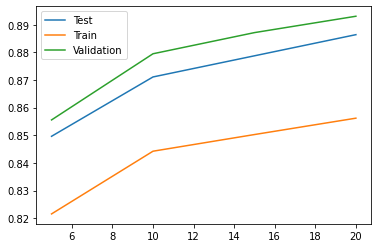

In [20]:
plt.plot([5,10,15,20], test_accuracies, label="Test")
plt.plot([5,10,15,20], train_accuracies, label="Train")
plt.plot([5,10,15,20], val_accuracies, label="Validation")
plt.legend()

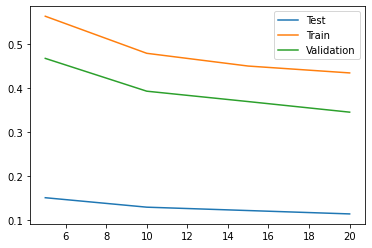

In [21]:
plt.plot([5,10,15,20], test_losses, label="Test")
plt.plot([5,10,15,20], train_losses, label="Train")
plt.plot([5,10,15,20], val_losses, label="Validation")
plt.legend()

In [22]:
model = copy.deepcopy(model_ft)
optimizer_ft = optim.SGD(model.fc.parameters(), lr=0.01)
model, hist_, best_acc, best_loss, train_acc, train_loss = train_model(model, dataloaders_dict, criterion, optimizer_ft, num_epochs=20)

predictions = []
label = []
running_corrects, test_acc = 0.0 , 0
for inputs, labels in test_dl:
    model.eval()
    outputs = model(inputs.cuda())
    _, preds = torch.max(outputs, 1)
    predictions.append(int(preds.detach().data))
    label.append(int(labels.data))
    running_corrects += torch.sum(preds.cpu() == labels.data)
test_acc = running_corrects / len(test_dl.dataset)
print('test accuracy: {}'.format(test_acc))

Epoch 0/19
----------
train Loss: 1.2019 Acc: 0.6579
val Loss: 0.7712 Acc: 0.8017

Epoch 1/19
----------
train Loss: 0.7446 Acc: 0.7808
val Loss: 0.6150 Acc: 0.8284

Epoch 2/19
----------
train Loss: 0.6385 Acc: 0.8082
val Loss: 0.5301 Acc: 0.8464

Epoch 3/19
----------
train Loss: 0.6010 Acc: 0.8143
val Loss: 0.4862 Acc: 0.8575

Epoch 4/19
----------
train Loss: 0.5588 Acc: 0.8248
val Loss: 0.4681 Acc: 0.8563

Epoch 5/19
----------
train Loss: 0.5326 Acc: 0.8330
val Loss: 0.4343 Acc: 0.8691

Epoch 6/19
----------
train Loss: 0.5120 Acc: 0.8367
val Loss: 0.4354 Acc: 0.8620

Epoch 7/19
----------
train Loss: 0.5082 Acc: 0.8344
val Loss: 0.4078 Acc: 0.8768

Epoch 8/19
----------
train Loss: 0.4880 Acc: 0.8421
val Loss: 0.4038 Acc: 0.8756

Epoch 9/19
----------
train Loss: 0.4837 Acc: 0.8438
val Loss: 0.3918 Acc: 0.8783

Epoch 10/19
----------
train Loss: 0.4664 Acc: 0.8497
val Loss: 0.3910 Acc: 0.8768

Epoch 11/19
----------
train Loss: 0.4681 Acc: 0.8453
val Loss: 0.3829 Acc: 0.8775

Ep

In [23]:
print(classification_report(label,predictions))

              precision    recall  f1-score   support

           0       0.92      0.91      0.92       452
           1       0.95      0.89      0.92       462
           2       0.91      0.86      0.89       479
           3       0.83      0.79      0.81       378
           4       0.95      0.94      0.94       367
           5       0.81      0.91      0.86       284
           6       0.87      0.85      0.86       390
           7       0.91      0.97      0.94       456
           8       0.84      0.84      0.84       375
           9       0.88      0.93      0.91       407

    accuracy                           0.89      4050
   macro avg       0.89      0.89      0.89      4050
weighted avg       0.89      0.89      0.89      4050



## Custom MLP

In [0]:
folder_test = ImageFolder('/content/data/test', transform=transforms.ToTensor())
folder_train = ImageFolder('/content/data/train', transform=transforms.ToTensor())
folder_val = ImageFolder('/content/data/val', transform=transforms.ToTensor())

For the normalization of the images, their mean and standard deviation is computed. 

In [10]:
mean = 0.0
std = 0.0 
for image, label in folder_train:
    mean += image.mean()
    std += image.std()

mean = float(mean) / len(folder_train)
std = float(std) / len(folder_train)
print(mean)
print(std)

0.37761806588955027
0.09477334320229829


The Data Augemnation techniques that are applied here is RandomHorizontalFlip that mirrors the image with a probability of 0,5 and RandomGrayScale that transforms an image to grayscale with 0,1 probability.

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomGrayscale(),
        transforms.ToTensor(),
        transforms.Normalize(mean = mean, std = std)
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean = mean, std = std)
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean = mean, std = std)
    ])
}

In [0]:
folder_test = ImageFolder('/content/data/test', transform=data_transforms['test'])
folder_train = ImageFolder('/content/data/train', transform=data_transforms['train'])
folder_val = ImageFolder('/content/data/val', transform=data_transforms['val'])

Normalization techniques that are applied here are the followingL

*    Batch Normalization: This method is used for the input normalization acccording to its mean and variance, as well as other learnable parameters.
*    DropOut: This techique performs random and independent channel deactivation with p probability for every forward pass. 
*    L2 Regularization: L2 Regularization bounds the total norm (euclidean norm) of the weights of a layer, in order to prohibit the update of the weigths with high values.

The logic applied to the design of the following network is that initially at the conv_features stage small sized kernels are used in order to capture as many feautres as possible. As the layers progress the size of the kernels increases, while the channels increase before the flattening phase of the network and the fully-connected part. In the latter stage, at eachc layer the number of nodes decrease in order to propagate all the information learnt by the network to the last 10 nodes.

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_features = nn.Sequential(
          nn.Conv2d(3, 6, 3), 
          nn.Conv2d(6, 10, 3), 
          nn.ReLU(inplace=True),
          nn.MaxPool2d(2, 2), 
          nn.BatchNorm2d(num_features=10),  
          nn.Dropout2d(p=0.5),
          nn.Conv2d(10, 16, 5), 
          nn.Conv2d(16, 16, 5), 
          nn.ReLU(inplace=True),
          nn.MaxPool2d(4, 4)
        )
        
        self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(16 * 5 * 5, 240),
          nn.ReLU(inplace=True),
          nn.Linear(240, 120),
          nn.ReLU(inplace=True),
          nn.Linear(120, 10)
        )

        self.l2_reg_list = [
          self.conv_features[0],
          self.classifier[1]                     
        ]

    def forward(self, x):
        x = self.conv_features(x)
        x = self.classifier(x)
        return x
    
    def l2_reg_loss(self):
        reg_loss = 0
        for layer in self.l2_reg_list:
            reg_loss += (layer.weight ** 2).sum().sqrt()
        return reg_loss

In [0]:
def customtrain(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc, best_loss = 0.0, 0.0
    langrangian_value = 0.1
    best_train_acc, best_train_loss = 0.0, 0.0


    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss_cls = criterion(outputs, labels)
                    loss_reg = model.l2_reg_loss()
                    loss = loss_cls + langrangian_value * loss_reg

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

            if phase == 'train' and epoch_acc > best_train_acc:
                best_train_acc = epoch_acc
                best_train_loss = epoch_loss

        
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, best_acc, best_loss, best_train_acc, best_train_loss
    model_ft = Net()


In [0]:
criterion= nn.CrossEntropyLoss()
model_ft = Net()

As shown above, during the validation stage different batch size values are examined. 

In [19]:
epoch = 10
best_accuracy = 0.0 
best_batchsize = 0
for batch_size in [100, 200, 500, 1000]:
    model = copy.deepcopy(model_ft)
    model.cuda()
    optimizer_ft = optim.Adam(model.parameters())
    train_dl = DataLoader(folder_train, batch_size=batch_size, shuffle=True)
    val_dl = DataLoader(folder_val, batch_size=batch_size)

    dataloaders_dict = {'train':train_dl,'val':val_dl}

    # Train and evaluate
    model, hist_, best_acc, _, _, _ = customtrain(model, dataloaders_dict, criterion, optimizer_ft, num_epochs=epoch)
    if best_acc > best_accuracy:
        best_accuracy = best_acc
        best_batchsize = batch_size

Epoch 0/9
----------
train Loss: 2.0451 Acc: 0.4329
val Loss: 1.4630 Acc: 0.6052

Epoch 1/9
----------
train Loss: 1.5198 Acc: 0.5634
val Loss: 1.2993 Acc: 0.6311

Epoch 2/9
----------
train Loss: 1.3494 Acc: 0.6269
val Loss: 1.1753 Acc: 0.6738

Epoch 3/9
----------
train Loss: 1.2735 Acc: 0.6449
val Loss: 1.1425 Acc: 0.6896

Epoch 4/9
----------
train Loss: 1.2065 Acc: 0.6676
val Loss: 1.0976 Acc: 0.7072

Epoch 5/9
----------
train Loss: 1.1696 Acc: 0.6783
val Loss: 1.0693 Acc: 0.7153

Epoch 6/9
----------
train Loss: 1.1399 Acc: 0.6859
val Loss: 0.9830 Acc: 0.7469

Epoch 7/9
----------
train Loss: 1.1246 Acc: 0.6940
val Loss: 0.9571 Acc: 0.7474

Epoch 8/9
----------
train Loss: 1.1139 Acc: 0.6940
val Loss: 0.9225 Acc: 0.7615

Epoch 9/9
----------
train Loss: 1.0638 Acc: 0.7065
val Loss: 0.9787 Acc: 0.7267

Training complete in 3m 20s
Best val Acc: 0.761481
Epoch 0/9
----------
train Loss: 2.2327 Acc: 0.4037
val Loss: 1.6144 Acc: 0.6185

Epoch 1/9
----------
train Loss: 1.6274 Acc: 0.

In [20]:
print(best_batchsize)

100


In [0]:
train_dl = DataLoader(folder_train, batch_size=100, shuffle=True)
val_dl = DataLoader(folder_val, batch_size=100)
test_dl = DataLoader(folder_test)

dataloaders_dict = {'train':train_dl,'val':val_dl}

In [22]:
# Train and evaluate
metrics = dict()
for epoch in [5, 10, 15, 20]:
    model = copy.deepcopy(model_ft)
    model.cuda()
    optimizer_ft = optim.Adam(model.parameters())
    model, hist_, val_acc, val_loss, train_acc, train_loss = customtrain(model, dataloaders_dict, criterion, optimizer_ft, num_epochs=epoch)
    model.eval()
    running_corrects = 0
    running_loss = 0
    test_acc = 0.0
    test_loss = 0.0
    for inputs, labels in test_dl:
        model.eval()
        outputs = model(inputs.cuda())
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds.cpu() == labels.data)
        running_loss += torch.sum(preds.cpu() != labels.data)

    test_loss = int(running_loss) / len(test_dl.dataset)
    test_acc = int(running_corrects.data) / len(test_dl.dataset)
    print()
    print('Test accuracy: {}  Test Loss: {}'.format(test_acc, test_loss))
    metrics[epoch] = [test_acc, test_loss, val_acc, val_loss, train_acc, train_loss]

Epoch 0/4
----------
train Loss: 2.0523 Acc: 0.4288
val Loss: 1.6219 Acc: 0.5084

Epoch 1/4
----------
train Loss: 1.5330 Acc: 0.5505
val Loss: 1.2828 Acc: 0.6380

Epoch 2/4
----------
train Loss: 1.4097 Acc: 0.5871
val Loss: 1.2219 Acc: 0.6541

Epoch 3/4
----------
train Loss: 1.3131 Acc: 0.6224
val Loss: 1.1507 Acc: 0.6679

Epoch 4/4
----------
train Loss: 1.2565 Acc: 0.6402
val Loss: 1.0890 Acc: 0.7010

Training complete in 1m 40s
Best val Acc: 0.700988

Test accuracy: 0.6864197530864198  Test Loss: 0.3135802469135803
Epoch 0/9
----------
train Loss: 2.0384 Acc: 0.4330
val Loss: 1.4648 Acc: 0.5914

Epoch 1/9
----------
train Loss: 1.5124 Acc: 0.5626
val Loss: 1.2408 Acc: 0.6681

Epoch 2/9
----------
train Loss: 1.3500 Acc: 0.6176
val Loss: 1.1704 Acc: 0.6795

Epoch 3/9
----------
train Loss: 1.2763 Acc: 0.6417
val Loss: 1.1416 Acc: 0.6802

Epoch 4/9
----------
train Loss: 1.2332 Acc: 0.6593
val Loss: 1.0809 Acc: 0.7104

Epoch 5/9
----------
train Loss: 1.1728 Acc: 0.6802
val Loss: 0

In [0]:
test_accuracies, test_losses, val_accuracies, val_losses, train_accuracies, train_losses = [], [], [], [], [], []

for epoch in [5, 10,15,20]:
    test_accuracies.append(metrics[epoch][0])
    test_losses.append(metrics[epoch][1])
    val_accuracies.append(metrics[epoch][2])
    val_losses.append(metrics[epoch][3])
    train_accuracies.append(metrics[epoch][4])
    train_losses.append(metrics[epoch][5])

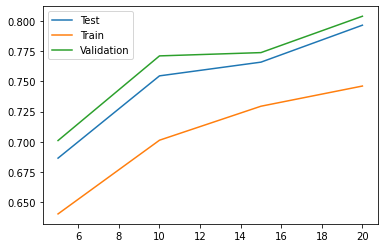

In [24]:
plt.plot([5,10,15,20], test_accuracies, label="Test")
plt.plot([5,10,15,20], train_accuracies, label="Train")
plt.plot([5,10,15,20], val_accuracies, label="Validation")
plt.legend()

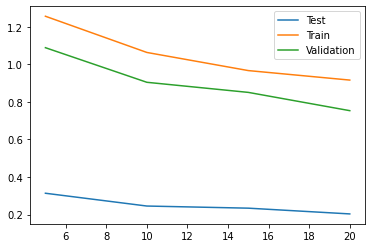

In [25]:
plt.plot([5,10,15,20], test_losses, label="Test")
plt.plot([5,10,15,20], train_losses, label="Train")
plt.plot([5,10,15,20], val_losses, label="Validation")
plt.legend()

In [32]:
model = copy.deepcopy(model_ft)
model.cuda()
optimizer_ft = optim.Adam(model.parameters())
model, hist_, best_acc, best_loss, train_acc, train_loss = customtrain(model, dataloaders_dict, criterion, optimizer_ft, num_epochs=20)

predictions = []
label = []
running_corrects, test_acc = 0 , 0.0
for inputs, labels in test_dl:
    model.eval()
    outputs = model(inputs.cuda())
    _, preds = torch.max(outputs, 1)
    predictions.append(int(preds.detach().data))
    label.append(int(labels.data))
    running_corrects += torch.sum(preds.cpu() == labels.data)
test_acc = int(running_corrects) / len(test_dl.dataset)
print('test accuracy: {}'.format(test_acc))

Epoch 0/19
----------
train Loss: 2.0692 Acc: 0.4209
val Loss: 1.4943 Acc: 0.6136

Epoch 1/19
----------
train Loss: 1.5269 Acc: 0.5521
val Loss: 1.3403 Acc: 0.6116

Epoch 2/19
----------
train Loss: 1.4235 Acc: 0.5884
val Loss: 1.2491 Acc: 0.6326

Epoch 3/19
----------
train Loss: 1.3202 Acc: 0.6185
val Loss: 1.1871 Acc: 0.6514

Epoch 4/19
----------
train Loss: 1.2528 Acc: 0.6401
val Loss: 1.0643 Acc: 0.6963

Epoch 5/19
----------
train Loss: 1.2031 Acc: 0.6582
val Loss: 1.1825 Acc: 0.6649

Epoch 6/19
----------
train Loss: 1.1573 Acc: 0.6747
val Loss: 0.9740 Acc: 0.7343

Epoch 7/19
----------
train Loss: 1.1190 Acc: 0.6829
val Loss: 1.0227 Acc: 0.7133

Epoch 8/19
----------
train Loss: 1.0776 Acc: 0.6951
val Loss: 0.9503 Acc: 0.7363

Epoch 9/19
----------
train Loss: 1.0832 Acc: 0.6966
val Loss: 0.9939 Acc: 0.7230

Epoch 10/19
----------
train Loss: 1.0560 Acc: 0.7041
val Loss: 0.9714 Acc: 0.7202

Epoch 11/19
----------
train Loss: 1.0533 Acc: 0.7031
val Loss: 0.8892 Acc: 0.7538

Ep

In [33]:
print(classification_report(label,predictions))

              precision    recall  f1-score   support

           0       0.92      0.78      0.84       452
           1       0.89      0.97      0.93       462
           2       0.73      0.63      0.67       479
           3       0.61      0.60      0.60       378
           4       0.84      0.87      0.86       367
           5       0.72      0.77      0.75       284
           6       0.58      0.75      0.65       390
           7       0.89      0.97      0.93       456
           8       0.74      0.57      0.65       375
           9       0.94      0.97      0.95       407

    accuracy                           0.79      4050
   macro avg       0.79      0.79      0.78      4050
weighted avg       0.79      0.79      0.79      4050



In [35]:
print(classes)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


As expected the second custom classifier did not reach the accuracy of the pre-trained Resnet model, since it does not exhibit neither the same depth, neither is trained with the same data volume.

The fact that precision, recall, and f1-score do not deviate from their weighted average in both classifiers is translated into a balanced test dataset. Therefore, the computed accuracy is considered valid due to the homogenous dataset.
